1- Calcular covarianzas para todos los volumenes

2- Calcular media covarianzas

3- Diferenciar/Calcular entre vendors

4- Para vendor A calcular valor metrica tomando Ct como la media de covarianzas vendor B.
Podemos cargar el modelo entrenado con los conjuntos de entrenamiento (vendor A y B) y calcular el coral para cuando le pasamos casos de test (no vistos) de vendors vistos (A y B) y no vistos (C y D)

-> Calcular media/ratio de pixeles para cada categoria en cada volumen (es estable?). Comparar tambien con predicciones buenas/malas. Por volumen!

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
import plotly
import plotly.figure_factory as ff
import numpy as np
import uuid
import monai

In [2]:
import sys
sys.path.append('../')
from utils.datasets import *
from utils.data_augmentation import *
from utils.dataload import * 
from models import model_selector

In [3]:
%matplotlib inline
import torch.nn.functional as F
from ipywidgets import interactive, interact

from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')
%config Completer.use_jedi = False

In [4]:
def coral(source, target):

    d = source.size(1)  # dim vector

    source_c = compute_covariance(source)
    target_c = compute_covariance(target)

    loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))

    loss = loss / (4 * d * d)
    return loss

In [5]:
def compute_covariance(input_data):
    """
    Compute Covariance matrix of the input data
    """
    n = input_data.size(0)  # batch_size

    # Check if using gpu or cpu
    if input_data.is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    id_row = torch.ones(n).reshape(1, n).to(device=device)
    sum_column = torch.mm(id_row, input_data)
    mean_column = torch.div(sum_column, n)
    term_mul_2 = torch.mm(mean_column.t(), mean_column)
    d_t_d = torch.mm(input_data.t(), input_data)
    c = torch.add(d_t_d, (-1 * term_mul_2)) * 1 / (n - 1)

    return c

In [6]:
def mask_2_onehot(mask, num_classes):
    """
    Transform multiclass mask [h, w] to [num_classes, h, w]
    """
    class_slice = []
    for c_class in range(num_classes+1):
        class_slice.append( ((mask == c_class) * 1) )
    return torch.stack(class_slice)

def volume_mask_2_onehot(mask, num_classes):
    """
    Transform multiclass mask [slices, h, w] to [num_classes, h, w]
    """
    slices = []
    for mask_slice in mask:
        slices.append( mask_2_onehot(mask_slice, num_classes=num_classes) )
    return torch.stack(slices)

In [7]:
def read_files(load_dir, extension=".pt"):
    paths = []
    for subdir, dirs, files in os.walk(load_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file_path.endswith(extension):
                paths.append(file_path)
    #if not len(paths):
    #        assert False, f"Could not find any file at '{load_dir}'"
    return paths

In [8]:
%matplotlib inline

## Covariances

In [9]:
vendor = "A"
normalization="none"
data_mod=""
verbose=False

add_depth = False
batch_size = 1

data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"

train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method, verbose=verbose
)

dataset = f"mms_vendor{vendor}{data_mod}"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs3DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

In [10]:
batch = next(iter(train_loader))

In [23]:
slice_indx = 0

batch_image = batch["volume"]
print(f"[Image] batch shape: {batch_image.shape}")
first_volume = batch_image[0]
print(f"[Image] first_volume: {first_volume.shape}")
first_slice = first_volume[0, slice_indx, ...]
print(f"[Image] first_slice: {first_slice.shape}")


print("---------------------------------------------")

batch_mask = batch["label"]
print(f"[Mask] batch shape: {batch_mask.shape}")
first_volume_mask = batch_mask[0]
print(f"[Mask] first_volume: {first_volume_mask.shape}")
first_slice_mask = first_volume_mask[0, slice_indx, ...]
print(f"[Mask] first_slice: {first_slice_mask.shape}")

[Image] batch shape: torch.Size([1, 1, 13, 224, 224])
[Image] first_volume: torch.Size([1, 13, 224, 224])
[Image] first_slice: torch.Size([224, 224])
---------------------------------------------
[Mask] batch shape: torch.Size([1, 1, 13, 224, 224])
[Mask] first_volume: torch.Size([1, 13, 224, 224])
[Mask] first_slice: torch.Size([224, 224])


In [24]:
vol_resized = F.interpolate(batch_image, size=(13,224,224))
mask_resized = F.interpolate(batch_mask, size=(13,224,224))
depth = vol_resized.shape[2]
vol_resized.shape

torch.Size([1, 1, 13, 224, 224])

In [25]:
@interact(display=(0,depth-1,1))
def show_volume(display=0):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,7))

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(vol_resized[0,0,display,...], cmap="gray")
    ax1.set_title("Image")
    ax2.imshow(mask_resized[0,0,display,...], cmap="gray", vmin=0, vmax=3)
    ax2.set_title("Mask")
    
    masked = np.ma.masked_where(mask_resized[0,0,display,...] == 0, mask_resized[0,0,display,...])
    ax3.imshow(vol_resized[0,0,display,...], cmap="gray")
    ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25, vmin=0, vmax=3)
    ax3.set_title("Overlay")
    
    plt.show()

interactive(children=(IntSlider(value=0, description='display', max=12), Output()), _dom_classes=('widget-inte…

In [26]:
video_duration = 3  # seconds duration animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

ax1.axis('off')
ax2.axis('off')

im = ax1.imshow(vol_resized[0,0,0,...], cmap="gray", interpolation='nearest')
ma = ax2.imshow(mask_resized[0,0,0,...], cmap="gray", vmin=0, vmax=3)
scene = [im, ma]

# initialization function: plot the background of each frame
def init():
    scene[0].set_data(vol_resized[0,0,0,...])
    scene[1].set_data(mask_resized[0,0,0,...])
    return scene

# animation function.  This is called sequentially
def animate(i):
    scene[0].set_data(vol_resized[0,0,i,...])
    scene[1].set_data(mask_resized[0,0,i,...])
    return scene

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=depth, interval=(video_duration*1000)//depth, blit=True, repeat=False
)
plt.close()

In [27]:
anim

In [14]:
#anim.save('animation.gif', writer='imagemagick', fps=depth//3)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=100)
anim.save('animation.mp4', writer=writer)

In [28]:
first_volume_1hot = volume_mask_2_onehot(first_volume_mask.squeeze(), 3)
print(f"Mask volume before: {first_volume_mask.shape} / after: {first_volume_1hot.shape}")

Mask volume before: torch.Size([1, 13, 224, 224]) / after: torch.Size([13, 4, 224, 224])


In [29]:
first_volume_1hot_flat = first_volume_1hot.permute(0,2,3,1).contiguous().view(-1, 4)
print(f"OneHot Mask before: {first_volume_1hot.shape} / after: {first_volume_1hot_flat.shape}")

OneHot Mask before: torch.Size([13, 4, 224, 224]) / after: torch.Size([652288, 4])


In [30]:
compute_covariance( first_volume_1hot_flat.float() )

tensor([[ 9.4670e-01, -3.9285e-08, -1.8886e-08, -1.9180e-08],
        [-3.9285e-08,  2.7068e-02, -5.3998e-10, -5.4838e-10],
        [-1.8886e-08, -5.3998e-10,  1.3013e-02, -2.6363e-10],
        [-1.9180e-08, -5.4838e-10, -2.6363e-10,  1.3215e-02]])

# 2. Compute Covariance for ALL & Mean

In [31]:
from tqdm.notebook import tqdm

### Labeled Vendor A

In [8]:
vendor = "A"
normalization="none"
data_mod=""
verbose=False

add_depth = False
batch_size = 1

data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"

train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method, verbose=verbose
)

dataset = f"mms_vendor{vendor}{data_mod}"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs3DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

In [12]:
save_dir = f"vendor{vendor}"
os.makedirs(save_dir, exist_ok=True)

In [13]:
for indx, batch in enumerate(tqdm(train_loader)):

    id_volume = batch["volume_id"][0]
    
    batch_image = batch["volume"]
    img_volume = batch_image[0]

    batch_mask = batch["label"]
    mask_volume = batch_mask[0]

    
    mask_volume_1hot = volume_mask_2_onehot(mask_volume.squeeze(), 3)
    mask_volume_1hot_flat = mask_volume_1hot.permute(0,2,3,1).contiguous().view(-1, 4)
    cov = compute_covariance( mask_volume_1hot_flat.float() )
    
    torch.save(cov, os.path.join(save_dir, f"{id_volume}.pt"))

  0%|          | 0/150 [00:00<?, ?it/s]

#### Calcular media covarianzas vendor A

In [308]:
paths = read_files("vendorA")

total = []
for path in paths:
    cov = torch.load(path)
    total.append(cov)
A_covs = torch.stack(total) 
avg_A = A_covs.mean(dim=0)
std_A = A_covs.std(dim=0)

### Labeled Vendor B

In [16]:
vendor = "B"
normalization="none"
data_mod=""
verbose=False

add_depth = False
batch_size = 1

data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"

train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method, verbose=verbose
)

dataset = f"mms_vendor{vendor}{data_mod}"

only_end = False if "full" in dataset else True
unlabeled = True if "unlabeled" in dataset else False
c_centre = find_values(dataset, "centre", int)
c_vendor = find_values(dataset, "vendor", str)


train_dataset = MMs3DDataset(
    partition="Training", transform=train_aug, img_transform=train_aug_img, 
    normalization=normalization, add_depth=add_depth, 
    is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
    end_volumes=only_end, data_relative_path="../"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

In [17]:
save_dir = f"vendor{vendor}"
os.makedirs(save_dir, exist_ok=True)

In [18]:
for indx, batch in enumerate(tqdm(train_loader)):

    id_volume = batch["volume_id"][0]
    
    batch_image = batch["volume"]
    img_volume = batch_image[0]

    batch_mask = batch["label"]
    mask_volume = batch_mask[0]

    
    mask_volume_1hot = volume_mask_2_onehot(mask_volume.squeeze(), 3)
    mask_volume_1hot_flat = mask_volume_1hot.permute(0,2,3,1).contiguous().view(-1, 4)
    cov = compute_covariance( mask_volume_1hot_flat.float() )
    
    torch.save(cov, os.path.join(save_dir, f"{id_volume}.pt"))

  0%|          | 0/150 [00:00<?, ?it/s]

#### Calcular media covarianzas vendor B

In [146]:
paths = read_files("vendorB")
        
total = []
for path in paths:
    cov = torch.load(path)
    total.append(cov)
B_covs = torch.stack(total)
avg_B = B_covs.mean(dim=0)
std_B = B_covs.std(dim=0)

### Analysis

In [124]:
avg_A+1

tensor([[1.9603, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0143, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0132, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0122]])

In [125]:
std_A+1

tensor([[1.0157, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0080, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0049, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0059]])

In [126]:
avg_B+1

tensor([[1.9610, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0122, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0138, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0131]])

In [127]:
std_B+1

tensor([[1.0156, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0067, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0054, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0068]])

# 3.  Predictions

Estudiar si existen diferencias entre los casos donde las predicciones son malas y donde son buenas entre las matrices de covarianzas. Añadir tambien las matrices originales (las presentes en entrenamiento / ground truth)

In [81]:
img_size = 224
val_transform = albumentations.Compose([
    albumentations.PadIfNeeded(min_height=img_size, min_width=img_size, always_apply=True),
    albumentations.CenterCrop(height=img_size, width=img_size, always_apply=True),
    albumentations.Resize(img_size, img_size, always_apply=True)
])

In [23]:
preds_dir = "res18_preds"

In [27]:
preds_df = pd.read_csv(os.path.join(preds_dir, "test_predictions", "results_20210112_0952.csv"))
dice_cols = [col for col in preds_df.columns if 'Dice' in col]
preds_df.groupby(['Vendor'])[dice_cols].mean()

,Dice LV,Dice MYO,Dice RV
Vendor,,,
A,0.924984,0.825245,0.892014
B,0.911199,0.861778,0.879801
C,0.904057,0.825972,0.878108
D,0.895773,0.808930,0.793612


In [28]:
preds_df.head()

,Name,ED/ES,Vendor,Centre,Dice LV,Jaccard LV,Hausdorff LV,ASSD LV,Dice MYO,Jaccard MYO,Hausdorff MYO,ASSD MYO,Dice RV,Jaccard RV,Hausdorff RV,ASSD RV
0,A1K2P5_sa_ED_gt,ED,D,5,0.963692,0.929929,3.977500,0.216245,0.829907,0.709266,33.769805,0.766280,0.902188,0.821805,14.029309,0.595209
1,A1K2P5_sa_ES_gt,ES,D,5,0.934224,0.876566,4.773000,0.267470,0.890507,0.802624,41.282474,1.358141,0.878020,0.782563,10.125773,1.074117
2,A2H5K9_sa_ED_gt,ED,B,2,0.948188,0.901480,6.367593,0.345248,0.869075,0.768463,12.487028,0.438937,0.906637,0.829219,11.616956,1.495611
3,A2H5K9_sa_ES_gt,ES,B,2,0.826251,0.703942,6.029246,0.653044,0.864478,0.761305,38.434024,1.369414,0.841117,0.725799,10.870874,0.768815
4,A2L1N6_sa_ED_gt,ED,A,1,0.960551,0.924097,51.025277,0.559432,0.867448,0.765923,9.806829,0.346739,0.947558,0.900342,6.010407,0.241222


Para realizar la comparacion con las matrices de covarianzas solo vamos a tomar los casos de los mismos vendor, A y B

In [312]:
jaccard_bad_th = 0.4
jaccard_regular = 0.7

A_all_cases = preds_df.loc[preds_df["Vendor"]=="A"]
A_bad_cases = A_all_cases.loc[A_all_cases["Jaccard LV"]<=jaccard_bad_th]
A_regular_cases = A_all_cases.loc[(A_all_cases["Jaccard LV"]>jaccard_bad_th) & (A_all_cases["Jaccard LV"]<jaccard_regular)]
A_good_cases = A_all_cases.loc[A_all_cases["Jaccard LV"]>=jaccard_regular]

B_all_cases = preds_df.loc[preds_df["Vendor"]=="B"]
B_bad_cases = B_all_cases.loc[B_all_cases["Jaccard LV"]<=jaccard_bad_th]
B_regular_cases = B_all_cases.loc[(B_all_cases["Jaccard LV"]>jaccard_bad_th) & (B_all_cases["Jaccard LV"]<jaccard_regular)]
B_good_cases = B_all_cases.loc[B_all_cases["Jaccard LV"]>=jaccard_regular]

C_all_cases = preds_df.loc[preds_df["Vendor"]=="C"]
C_bad_cases = C_all_cases.loc[C_all_cases["Jaccard LV"]<=jaccard_bad_th]
C_regular_cases = C_all_cases.loc[(C_all_cases["Jaccard LV"]>jaccard_bad_th) & (C_all_cases["Jaccard LV"]<jaccard_regular)]
C_good_cases = C_all_cases.loc[C_all_cases["Jaccard LV"]>=jaccard_regular]

D_all_cases = preds_df.loc[preds_df["Vendor"]=="D"]
D_bad_cases = D_all_cases.loc[D_all_cases["Jaccard LV"]<=jaccard_bad_th]
D_regular_cases = D_all_cases.loc[(D_all_cases["Jaccard LV"]>jaccard_bad_th) & (D_all_cases["Jaccard LV"]<jaccard_regular)]
D_good_cases = D_all_cases.loc[D_all_cases["Jaccard LV"]>=jaccard_regular]

print(f"[Vendor A] Bad Cases: {len(A_bad_cases)} / Regular Cases: {len(A_regular_cases)} / Good Cases: {len(A_good_cases)}")
print(f"[Vendor B] Bad Cases: {len(B_bad_cases)} / Regular Cases: {len(B_regular_cases)} / Good Cases: {len(B_good_cases)}")
print(f"[Vendor C] Bad Cases: {len(C_bad_cases)} / Regular Cases: {len(C_regular_cases)} / Good Cases: {len(C_good_cases)}")
print(f"[Vendor D] Bad Cases: {len(D_bad_cases)} / Regular Cases: {len(D_regular_cases)} / Good Cases: {len(D_good_cases)}")

[Vendor A] Bad Cases: 0 / Regular Cases: 1 / Good Cases: 31
[Vendor B] Bad Cases: 0 / Regular Cases: 8 / Good Cases: 72
[Vendor C] Bad Cases: 1 / Regular Cases: 3 / Good Cases: 76
[Vendor D] Bad Cases: 0 / Regular Cases: 13 / Good Cases: 67


In [342]:
C_bad_cases

,Name,ED/ES,Vendor,Centre,Dice LV,Jaccard LV,Hausdorff LV,ASSD LV,Dice MYO,Jaccard MYO,Hausdorff MYO,ASSD MYO,Dice RV,Jaccard RV,Hausdorff RV,ASSD RV
83,C8O0P2_sa_ES_gt,ES,C,4,0.508616,0.341036,34.188011,4.694153,0.763588,0.617584,27.512867,3.127858,0.858954,0.752778,12.453356,0.531067


In [327]:
def preds_covs(vendor, vendor_cases):
    bad_dir = f"vendor{vendor}_preds_bad"
    regular_dir = f"vendor{vendor}_preds_regular"
    good_dir = f"vendor{vendor}_preds_good"
    os.makedirs(bad_dir, exist_ok=True)
    os.makedirs(regular_dir, exist_ok=True)
    os.makedirs(good_dir, exist_ok=True)

    for index, row in vendor_cases.iterrows():

        if row["Jaccard LV"]<=jaccard_bad_th:
            save_dir = bad_dir
        elif row["Jaccard LV"]>jaccard_bad_th and row["Jaccard LV"]<jaccard_regular:
            save_dir = regular_dir
        else:
            save_dir = good_dir

        name = row["Name"][:-3]
        pred_path = os.path.join(preds_dir, "test_predictions", f"{name}.nii.gz")

        if not os.path.isfile(pred_path): assert False, f"Error with: {pred_path}"

        mask_pred = load_nii(pred_path)[0]
        mask_pred = mask_pred.transpose(2,0,1)
        mask_pred = apply_volume_2Daugmentations(mask_pred, val_transform, None, mask_pred)[0]
        mask_pred = torch.tensor(mask_pred)

        mask_volume_1hot = volume_mask_2_onehot(mask_pred.squeeze(), 3)
        mask_volume_1hot_flat = mask_volume_1hot.permute(0,2,3,1).contiguous().view(-1, 4)
        cov = compute_covariance( mask_volume_1hot_flat.float() )

        torch.save(cov, os.path.join(save_dir, f"{name}.pt"))

        ##################################################################
        paths = read_files(f"vendor{vendor}_preds_bad")
        total, bad_covs = [], torch.tensor([])
        for path in paths:
            cov = torch.load(path)
            total.append(cov)
        if len(paths):
            bad_covs = torch.stack(total)
            avg_bad = bad_covs.mean(dim=0)
            std_bad = bad_covs.std(dim=0)

        # --------------------------------------------------------------

        paths = read_files(f"vendor{vendor}_preds_regular")
        total, regular_covs = [], torch.tensor([])
        for path in paths:
            cov = torch.load(path)
            total.append(cov)
        if len(paths):
            regular_covs = torch.stack(total)
            avg_regular = regular_covs.mean(dim=0)
            std_regular = regular_covs.std(dim=0)

        # --------------------------------------------------------------

        paths = read_files(f"vendor{vendor}_preds_good")
        total, good_covs = [], torch.tensor([])
        for path in paths:
            cov = torch.load(path)
            total.append(cov)
        if len(paths):
            good_covs = torch.stack(total)
            avg_good = good_covs.mean(dim=0)
            std_good = good_covs.std(dim=0)
    
    return bad_covs, regular_covs, good_covs

In [348]:
A_bad_covs, A_regular_covs, A_good_covs = preds_covs("A", A_all_cases)
B_bad_covs, B_regular_covs, B_good_covs = preds_covs("B", B_all_cases)
C_bad_covs, C_regular_covs, C_good_covs = preds_covs("C", C_all_cases)
D_bad_covs, D_regular_covs, D_good_covs = preds_covs("D", D_all_cases)

### TSNE

In [329]:
from sklearn.manifold import TSNE
from bioinfokit.visuz import cluster

In [339]:
all_covs = torch.cat((
    A_bad_covs, A_regular_covs, A_good_covs, A_covs, 
    B_bad_covs, B_regular_covs, B_good_covs, B_covs, 
    C_bad_covs, C_regular_covs, C_good_covs, #C_covs, 
    D_bad_covs, D_regular_covs, D_good_covs, #D_covs, 
))
data = all_covs.view(len(all_covs), -1).numpy()

named_labels = ["A_bad"]*len(A_bad_covs) 
named_labels.extend(["A_regular"]*len(A_regular_covs))
named_labels.extend(["A_good"]*len(A_good_covs))
named_labels.extend(["A_covs"]*len(A_covs))

named_labels.extend(["B_bad"]*len(B_bad_covs))
named_labels.extend(["B_regular"]*len(B_regular_covs))
named_labels.extend(["B_good"]*len(B_good_covs))
named_labels.extend(["B_covs"]*len(B_covs))

named_labels.extend(["C_bad"]*len(C_bad_covs))
named_labels.extend(["C_regular"]*len(C_regular_covs))
named_labels.extend(["C_good"]*len(C_good_covs))
#named_labels.extend(["C_covs"]*len(C_covs))

named_labels.extend(["C_bad"]*len(D_bad_covs))
named_labels.extend(["C_regular"]*len(D_regular_covs))
named_labels.extend(["C_good"]*len(D_good_covs))
#named_labels.extend(["C_covs"]*len(D_covs))


#named_labels = ["bad"]*len(A_bad_covs) + ["good"]*len(A_good_covs) + ["original"]*len(A_covs) + ["bad"]*len(B_bad_covs) + ["good"]*len(B_good_covs) + ["original"]*len(B_covs)
#named_labels = ["bad"]*len(A_bad_covs) + ["good"]*len(A_good_covs) + ["original"]*len(A_covs) + ["bad"]*len(B_bad_covs) + ["good"]*len(B_good_covs) + ["original"]*len(B_covs)

num_classes = 4
covs_names = [f"cov_{x}_{i}" for x in range(num_classes) for i in range(num_classes)]

df = pd.DataFrame(data=data, columns=covs_names)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 428 samples in 0.001s...
[t-SNE] Computed neighbors for 428 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 428 / 428
[t-SNE] Mean sigma: 0.002954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.011459
[t-SNE] KL divergence after 1900 iterations: 0.345091


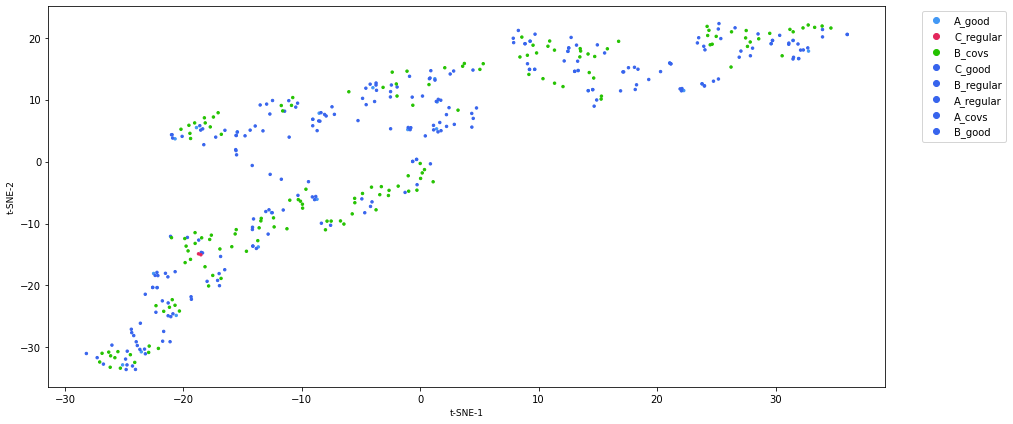

In [340]:
tsne_em = TSNE(n_components=2, perplexity=25.0, n_iter=2500, verbose=1).fit_transform(df)
cluster.tsneplot(
    score=tsne_em, colorlist=named_labels, legendpos='upper right', legendanchor=(1.15, 1), 
    show=True, dim=(15,7), figtype="pdf",
    #colordot=('#4298f5', '#ff42c6', '#ff4291', '#4254f5', '#ff426b', '#6642f5')
    colordot=('#4298f5', '#e3275c', '#80c470', '#24c200', '#ff426b', '#3764ed', '#3764ed', '#3764ed', '#3764ed', '#3764ed', '#3764ed', '#3764ed')
)

# 4. Coral Loss Seen vs. Unseen Vendors

Podemos cargar el modelo entrenado con los conjuntos de entrenamiento (vendor A y B) y calcular el coral para cuando le pasamos casos de test (no vistos) de vendors vistos (A y B) y no vistos (C y D)

In [9]:
model = model_selector(
    "segmentation", "resnet18_unet_scratch", 4, from_swa=False, in_channels=3, 
    checkpoint="../checks/resnet18_unet/model_resnet18_unet_scratch_best_iou.pt"
)
model.eval()
print("Model loaded!")

Model total number of parameters: 26181898
Loaded model from checkpoint: ../checks/resnet18_unet/model_resnet18_unet_scratch_best_iou.pt
Model loaded!


In [10]:
def get_dataset(vendor, add_depth = True, partition="Training"):

    normalization="standardize"
    data_mod=""
    verbose=False
    
    batch_size = 1

    data_augmentation = "none"
    img_size, crop_size = 224, 224 # We will take original image not transformed one
    mask_reshape_method = "padd"

    train_aug, train_aug_img, val_aug = data_augmentation_selector(
        data_augmentation, img_size, crop_size, mask_reshape_method, verbose=verbose
    )

    dataset = f"mms_vendor{vendor}{data_mod}"

    only_end = False if "full" in dataset else True
    unlabeled = True if "unlabeled" in dataset or partition == "Testing" else False
    c_centre = find_values(dataset, "centre", int)
    c_vendor = find_values(dataset, "vendor", str)


    dataset = MMs3DDataset(
        partition=partition, transform=train_aug, img_transform=train_aug_img, 
        normalization=normalization, add_depth=add_depth, 
        is_labeled=(not unlabeled), centre=c_centre, vendor=c_vendor, 
        end_volumes=only_end, data_relative_path="../"
    )

    loader = DataLoader(
        dataset, batch_size=batch_size, pin_memory=True,
        shuffle=False, collate_fn=dataset.custom_collate
    )
    
    return loader

In [11]:
loader_A_train = get_dataset("A")
loader_A_test = get_dataset("A", partition="Testing")
loader_B_train = get_dataset("B")
loader_B_test = get_dataset("B", partition="Testing")

loader_C_test = get_dataset("C", partition="Testing")
loader_D_test = get_dataset("D", partition="Testing")

In [16]:
def get_covs(loader, model):
    res = []
    model.eval()
    with torch.no_grad():
        for indx, batch in enumerate(tqdm(loader)):
            vol = batch["volume"]  # torch.Size([1, 13, 3, 224, 224])
            pred = model(vol.squeeze())
            pred_flat = pred.permute(0,2,3,1).contiguous().view(-1, 4)
            cov = compute_covariance( pred_flat.float() )
            res.append(cov)
    return torch.stack(res)

In [17]:
A_train_covs = get_covs(loader_A_train, model)
A_test_covs = get_covs(loader_A_test, model)
B_train_covs = get_covs(loader_B_train, model)
B_test_covs = get_covs(loader_B_test, model)

C_test_covs = get_covs(loader_C_test, model)
D_test_covs = get_covs(loader_D_test, model)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [9]:
covs_dir = "loader_covs"
os.makedirs(covs_dir, exist_ok=True)

In [ ]:
torch.save(A_train_covs, os.path.join(covs_dir, "A_train_covs.pt"))
torch.save(A_test_covs, os.path.join(covs_dir, "A_test_covs.pt"))
torch.save(B_train_covs, os.path.join(covs_dir, "B_train_covs.pt"))
torch.save(B_test_covs, os.path.join(covs_dir, "B_test_covs.pt"))

torch.save(C_test_covs, os.path.join(covs_dir, "C_test_covs.pt"))
torch.save(D_test_covs, os.path.join(covs_dir, "D_test_covs.pt"))

In [12]:
# -- Seen
A_train_covs = torch.load(os.path.join(covs_dir, "A_train_covs.pt"))
A_test_covs = torch.load(os.path.join(covs_dir, "A_test_covs.pt"))
B_train_covs = torch.load(os.path.join(covs_dir, "B_train_covs.pt"))
B_test_covs = torch.load(os.path.join(covs_dir, "B_test_covs.pt"))
# -- Unseen
C_test_covs = torch.load(os.path.join(covs_dir, "C_test_covs.pt"))
D_test_covs = torch.load(os.path.join(covs_dir, "D_test_covs.pt"))

In [55]:
AtrAte = []
AtrBtr = []
AtrBte = []
BtrBte = []
BtrAte = []

AtrCte = []
AtrDte = []
AteBte = []
AteCte = []
AteDte = []

BtrCte = []
BtrDte = []
BteCte = []
BteDte = []

for a_tr_cov in A_train_covs:
    
    for a_te_cov in A_test_covs:
        coral_loss = coral(a_tr_cov, a_te_cov)
        AtrAte.append(coral_loss.item())
    
    for b_tr_cov in B_train_covs:
        coral_loss = coral(a_tr_cov, b_tr_cov)
        AtrBtr.append(coral_loss.item())
        
    for b_te_cov in B_test_covs:
        coral_loss = coral(a_tr_cov, b_te_cov)
        AtrBte.append(coral_loss.item())
    
    for c_te_cov in C_test_covs:
        coral_loss = coral(a_tr_cov, c_te_cov)
        AtrCte.append(coral_loss.item())
    
    for d_te_cov in D_test_covs:
        coral_loss = coral(a_tr_cov, d_te_cov)
        AtrDte.append(coral_loss.item())
        
for a_te_cov in A_test_covs:
    
    for b_te_cov in B_test_covs:
        coral_loss = coral(a_te_cov, b_te_cov)
        AteBte.append(coral_loss.item()) 
    
    for c_te_cov in C_test_covs:
        coral_loss = coral(a_te_cov, c_te_cov)
        AteCte.append(coral_loss.item()) 
    
    for d_te_cov in D_test_covs:
        coral_loss = coral(a_te_cov, d_te_cov)
        AteDte.append(coral_loss.item())    
        
        
for b_tr_cov in B_train_covs:
    
    for a_te_cov in A_test_covs:
        coral_loss = coral(b_tr_cov, a_te_cov)
        BtrAte.append(coral_loss.item())
    
    for b_te_cov in B_test_covs:
        coral_loss = coral(b_tr_cov, b_te_cov)
        BtrBte.append(coral_loss.item())
    
    for c_te_cov in C_test_covs:
        coral_loss = coral(b_tr_cov, c_te_cov)
        BtrCte.append(coral_loss.item())
    
    for d_te_cov in D_test_covs:
        coral_loss = coral(b_tr_cov, d_te_cov)
        BtrDte.append(coral_loss.item())
        
for b_te_cov in B_test_covs:
    
    for c_te_cov in C_test_covs:
        coral_loss = coral(b_te_cov, c_te_cov)
        BteCte.append(coral_loss.item()) 
    
    for d_te_cov in D_test_covs:
        coral_loss = coral(b_te_cov, d_te_cov)
        BteDte.append(coral_loss.item())    

In [36]:
df_AtrAte = pd.DataFrame({'coral':AtrAte, 'info':["AtrAte"]*len(AtrAte)})
df_AtrBtr = pd.DataFrame({'coral':AtrBtr, 'info':["AtrBtr"]*len(AtrBtr)})
df_AtrBte = pd.DataFrame({'coral':AtrBte, 'info':["AtrBte"]*len(AtrBte)})
df_BtrBte = pd.DataFrame({'coral':BtrBte, 'info':["BtrBte"]*len(BtrBte)})

df_AtrCte = pd.DataFrame({'coral':AtrCte, 'info':["AtrCte"]*len(AtrCte)})
df_AtrDte = pd.DataFrame({'coral':AtrDte, 'info':["AtrDte"]*len(AtrDte)})

df_BtrCte = pd.DataFrame({'coral':BtrCte, 'info':["BtrCte"]*len(BtrCte)})
df_BtrDte = pd.DataFrame({'coral':BtrDte, 'info':["BtrDte"]*len(BtrDte)})

df_all_coral = pd.concat([ df_AtrAte, df_AtrBtr, df_AtrBte, df_BtrBte, df_AtrCte, df_AtrDte, df_BtrCte, df_BtrDte ])

In [44]:
df_AtrAte = pd.DataFrame({'coral':AtrAte, 'info':["Seen"]*len(AtrAte)})
df_AtrBtr = pd.DataFrame({'coral':AtrBtr, 'info':["Seen"]*len(AtrBtr)})
df_AtrBte = pd.DataFrame({'coral':AtrBte, 'info':["Seen"]*len(AtrBte)})
df_BtrBte = pd.DataFrame({'coral':BtrBte, 'info':["Seen"]*len(BtrBte)})

df_AtrCte = pd.DataFrame({'coral':AtrCte, 'info':["Unseen"]*len(AtrCte)})
df_AtrDte = pd.DataFrame({'coral':AtrDte, 'info':["Unseen"]*len(AtrDte)})

df_BtrCte = pd.DataFrame({'coral':BtrCte, 'info':["Unseen"]*len(BtrCte)})
df_BtrDte = pd.DataFrame({'coral':BtrDte, 'info':["Unseen"]*len(BtrDte)})

df_seen_unseen_coral = pd.concat([ df_AtrAte, df_AtrBtr, df_AtrBte, df_BtrBte, df_AtrCte, df_AtrDte, df_BtrCte, df_BtrDte ])

<AxesSubplot:xlabel='coral', ylabel='Density'>

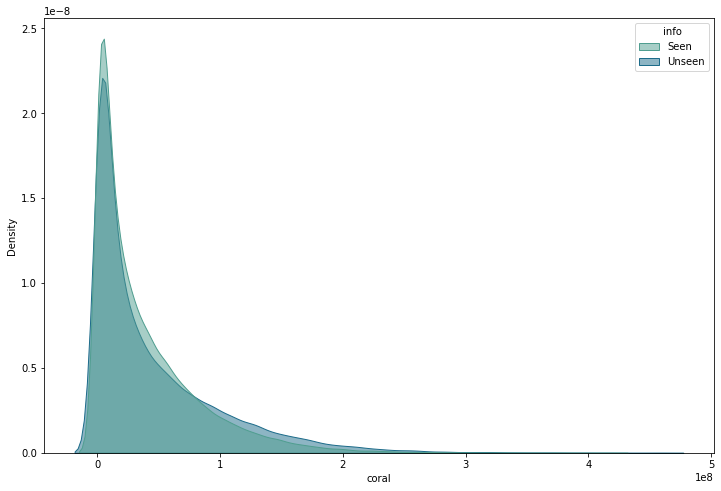

In [47]:
plt.figure(figsize=(12,8))
sns.kdeplot(
   data=df_seen_unseen_coral, x="coral", hue="info",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)

<AxesSubplot:xlabel='coral', ylabel='Density'>

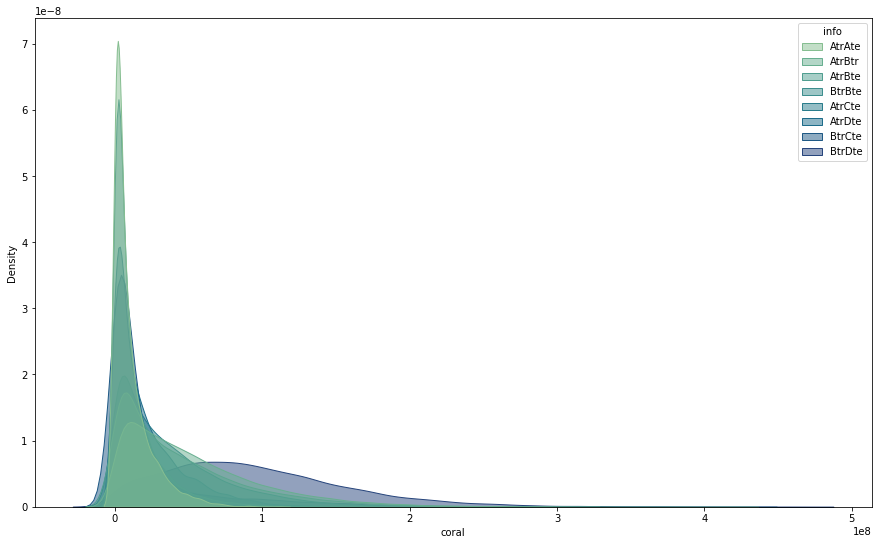

In [68]:
plt.figure(figsize=(15,9))
sns.kdeplot(
   data=df_all_coral, x="coral", hue="info",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)

In [93]:
df_AtrBte = pd.DataFrame({'coral':AtrBte, 'info':["AtrBte"]*len(AtrBte)})
df_AtrCte = pd.DataFrame({'coral':AtrCte, 'info':["AtrCte"]*len(AtrCte)})
df_AtrDte = pd.DataFrame({'coral':AtrDte, 'info':["AtrDte"]*len(AtrDte)})
df_AtrAte = pd.DataFrame({'coral':AtrAte, 'info':["AtrAte"]*len(AtrAte)})

df_1_coral = pd.concat([ df_AtrBte, df_AtrCte, df_AtrDte, df_AtrAte ])

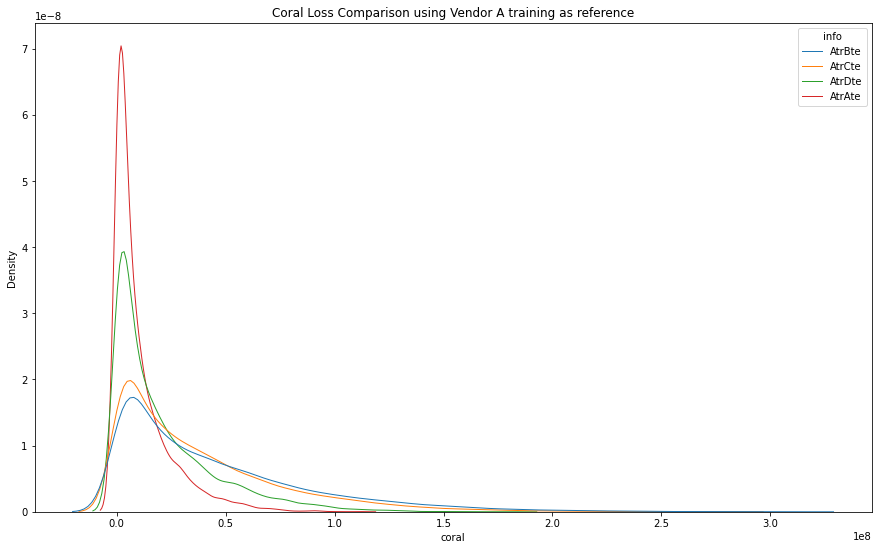

In [97]:
plt.figure(figsize=(15,9))
sns.kdeplot(
   data=df_1_coral, x="coral", hue="info",
   fill=False, common_norm=False, #palette="crest",
   alpha=.5, linewidth=1,
)
plt.title("Coral Loss Comparison using Vendor A training as reference")
plt.savefig("Atr.jpg", dpi=300)

In [98]:
df_BtrBte = pd.DataFrame({'coral':BtrBte, 'info':["BtrBte"]*len(BtrBte)})
df_BtrCte = pd.DataFrame({'coral':BtrCte, 'info':["BtrCte"]*len(BtrCte)})
df_BtrDte = pd.DataFrame({'coral':BtrDte, 'info':["BtrDte"]*len(BtrDte)})
df_BtrAte = pd.DataFrame({'coral':BtrAte, 'info':["BtrAte"]*len(AtrAte)})

df_1_coral = pd.concat([ df_BtrBte, df_BtrCte, df_BtrDte, df_BtrAte ])

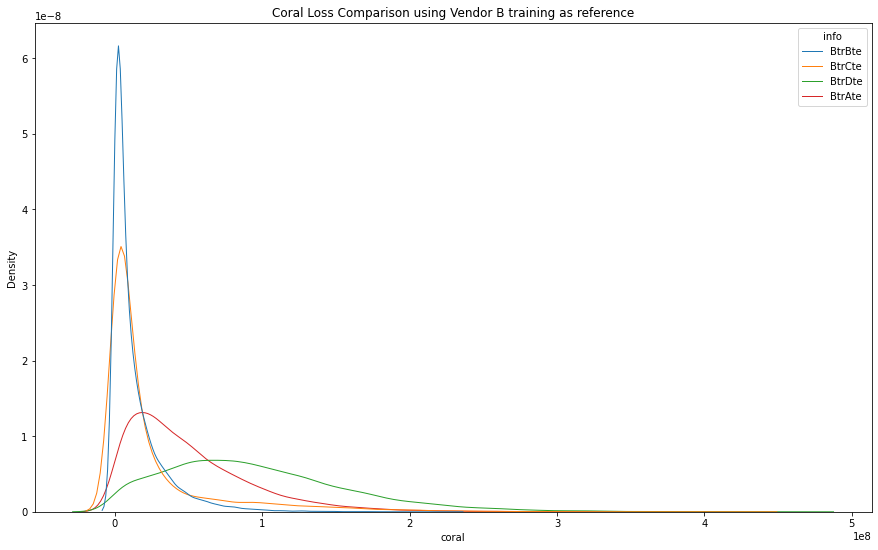

In [99]:
plt.figure(figsize=(15,9))
sns.kdeplot(
   data=df_1_coral, x="coral", hue="info",
   fill=False, common_norm=False, #palette="crest",
   alpha=.5, linewidth=1,
)
plt.title("Coral Loss Comparison using Vendor B training as reference")
plt.savefig("Btr.jpg", dpi=300)

In [90]:
df_BtrBte = pd.DataFrame({'coral':BtrBte, 'info':["BtrBte"]*len(BtrBte)})
df_BtrCte = pd.DataFrame({'coral':BtrCte, 'info':["BtrCte"]*len(BtrCte)})
df_BtrDte = pd.DataFrame({'coral':BtrDte, 'info':["BtrDte"]*len(BtrDte)})
df_BtrAte = pd.DataFrame({'coral':BtrAte, 'info':["BtrAte"]*len(AtrAte)})

df_AtrBte = pd.DataFrame({'coral':AtrBte, 'info':["AtrBte"]*len(AtrBte)})
df_AtrCte = pd.DataFrame({'coral':AtrCte, 'info':["AtrCte"]*len(AtrCte)})
df_AtrDte = pd.DataFrame({'coral':AtrDte, 'info':["AtrDte"]*len(AtrDte)})
df_AtrAte = pd.DataFrame({'coral':AtrAte, 'info':["AtrAte"]*len(AtrAte)})


df_1_coral = pd.concat([ df_BtrBte, df_BtrCte, df_BtrDte, df_BtrAte, df_AtrBte, df_AtrCte, df_AtrDte, df_AtrAte ])

<AxesSubplot:xlabel='coral', ylabel='Density'>

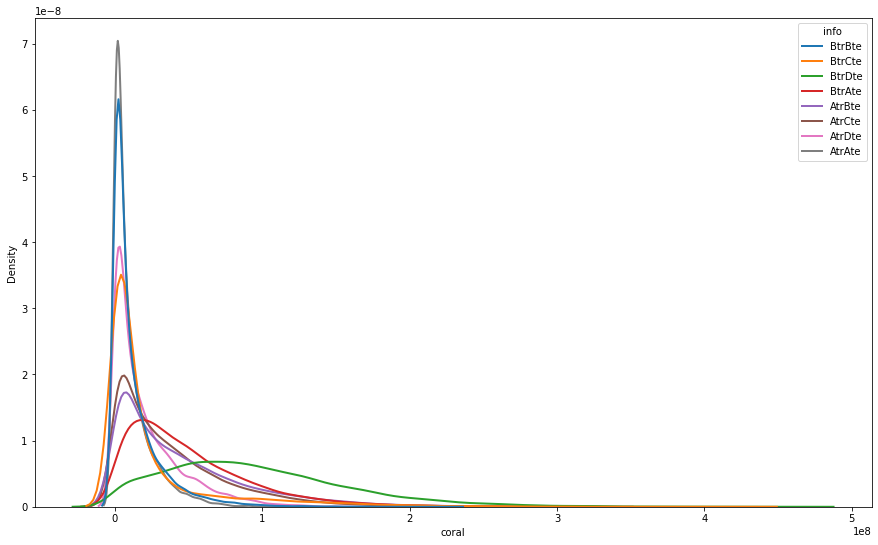

In [92]:
plt.figure(figsize=(15,9))
sns.kdeplot(
   data=df_1_coral, x="coral", hue="info",
   fill=False, common_norm=False, #palette="crest",
   alpha=.5, linewidth=2,
)

In [51]:
df_AtrCte = pd.DataFrame({'coral':AtrCte, 'info':["AtrCte"]*len(AtrCte)})
df_AtrDte = pd.DataFrame({'coral':AtrDte, 'info':["AtrDte"]*len(AtrDte)})

df_BtrCte = pd.DataFrame({'coral':BtrCte, 'info':["BtrCte"]*len(BtrCte)})
df_BtrDte = pd.DataFrame({'coral':BtrDte, 'info':["BtrDte"]*len(BtrDte)})

df_unseen_coral = pd.concat([ df_AtrCte, df_AtrDte, df_BtrCte, df_BtrDte ])

<AxesSubplot:xlabel='coral', ylabel='Density'>

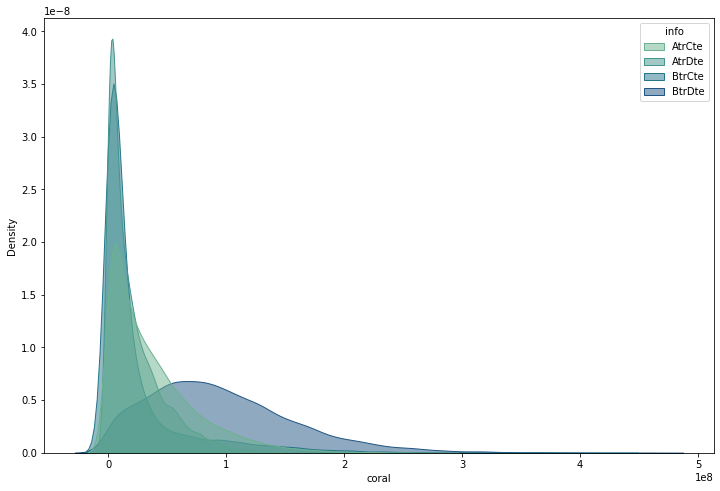

In [52]:
plt.figure(figsize=(12,8))
sns.kdeplot(
   data=df_unseen_coral, x="coral", hue="info",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)